In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
import csv

import sys

sys.path.append("../../")

In [2]:
show_animation = True
WORLD_SIZE = 500
# Vehicle parameters
NX = 5  # x = x,y,v,yaw,omega
NU = 2  # a = [velocity,steer]
DT = 0.5

# Vehicle parameters描画用らしい
LENGTH = 4.5  # [m]
WIDTH = 2  # [m]
BACKTOWHEEL = 1  # [m]
WHEEL_LEN = 0.3  # [m]
WHEEL_WIDTH = 0.2  # [m]
TREAD = 0.7  # [m]
WB = 2.5  # [m]

MAX_STEERING_ANGLE = math.radians(45.0)  # maximum steering angle [rad]
MAX_DSTEER = math.radians(30.0)  # maximum steering speed [rad/s]

In [3]:
class Config():
    # simulation parameters

    def __init__(self):
        # robot parameter
        self.max_speed = 5  # [m/s]
        self.min_speed = 0  # [m/s]
        self.max_yawrate = 40.0 * math.pi / 180.0  # [rad/s]
        self.max_accel = 0.5  # [m/ss]
        self.max_dyawrate = 40.0 * math.pi / 180.0  # [rad/ss]
        self.v_reso = 0.1  # [m/s]
        self.yawrate_reso = 1 * math.pi / 180.0  # [rad/s]
        self.dt = 0.5  # [s]
        self.predict_time = 1.0  # [s]
        self.to_goal_cost_gain = 0.0
        self.speed_cost_gain = 1.0
        self.ob_cost_gain = 0.0
        self.to_goal_dis_cost_gain = 1.0
        self.robot_radius = 1.0  # [m]

In [4]:
def motion(x, u, dt):
    # motion model for two-wheel robot x,y,orient,v,steering

    x[2] += u[1] * dt
    x[0] += u[0] * math.cos(x[2]) * dt
    x[1] += u[0] * math.sin(x[2]) * dt
    x[3] = u[0]
    x[4] = u[1]

    return x

In [5]:
def calc_dynamic_window(x, config):
    # Dynamic window from robot specification
    Vs = [config.min_speed, config.max_speed,
          -config.max_yawrate, config.max_yawrate]

    # Dynamic window from motion model
    Vd = [x[3] - config.max_accel * config.dt,
          x[3] + config.max_accel * config.dt,
          x[4] - config.max_dyawrate * config.dt,
          x[4] + config.max_dyawrate * config.dt]

    #  [vmin,vmax, yawrate min, yawrate max]
    dw = [max(Vs[0], Vd[0]), min(Vs[1], Vd[1]),
          max(Vs[2], Vd[2]), min(Vs[3], Vd[3])]

    return dw

In [6]:
def calc_trajectory(xinit, v, y, config):
    x = np.array(xinit)
    traj = np.array(x)
    time = 0
    while time <= config.predict_time:
        x = motion(x, [v, y], config.dt)
        traj = np.vstack((traj, x))
        time += config.dt

    return traj

In [7]:
def calc_final_input(x, u, dw, config, goal, ob):
    xinit = x[:]
    min_cost = 10000.0
    min_u = u
    min_u[0] = 0.0
    best_traj = np.array([x])

    # evalucate all trajectory with sampled input in dynamic window
    for v in np.arange(dw[0], dw[1], config.v_reso):
        for y in np.arange(dw[2], dw[3], config.yawrate_reso):
            traj = calc_trajectory(xinit, v, y, config)

            # calc cost
            to_goal_cost = config.to_goal_cost_gain * calc_to_goal_cost(traj, goal, config)
            to_goal_dis_cost = config.to_goal_dis_cost_gain * calc_to_goal_dis_cost(traj, goal, config)
            speed_cost = config.speed_cost_gain * \
                         (config.max_speed - traj[-1, 3])  # traj[-1,3] velocity
            # ob_cost = config.ob_cost_gain * calc_obstacle_cost(traj, ob, config)
            # print(ob_cost)

            final_cost = to_goal_cost + speed_cost + to_goal_dis_cost

            # search minimum trajectory
            if min_cost >= final_cost:
                min_cost = final_cost
                min_u = [v, y]
                best_traj = traj

    return min_u, best_traj

In [8]:
def calc_whole_subgoal_final_input(x, u, dw, config, goal_loc, main_index):
    xinit = x[:]
    min_cost = 10000.0
    min_u = u
    min_u[0] = 0.0
    best_traj = np.array([x])

    # evalucate all trajectory with sampled input in dynamic window
    for v in np.arange(dw[0], dw[1], config.v_reso):
        for y in np.arange(dw[2], dw[3], config.yawrate_reso):
            traj = calc_trajectory(xinit, v, y, config)

            # calc cost
            # to_goal_cost = config.to_goal_cost_gain * calc_to_goal_cost(traj, config)
            to_goal_dis_cost = config.to_goal_dis_cost_gain * calc_whole_sub_goal_dis_cost(traj, goal_loc, config,
                                                                                           main_index)

            speed_cost = config.speed_cost_gain * \
                         (config.max_speed - traj[-1, 3])  # traj[-1,3] velocity
            # ob_cost = config.ob_cost_gain * calc_obstacle_cost(traj, ob, config)
            # print(ob_cost)

            final_cost = to_goal_dis_cost + speed_cost

            # search minimum trajectory
            if min_cost >= final_cost:
                min_cost = final_cost
                min_u = [v, y]
                best_traj = traj

    return min_u, best_traj

In [9]:
def calc_obstacle_cost(traj, ob, config):
    # calc obstacle cost inf: collistion, 0:free

    skip_n = 2
    minr = float("inf")

    for ii in range(0, len(traj[:, 1]), skip_n):
        for i in range(len(ob[:, 0])):
            ox = ob[i, 0]
            oy = ob[i, 1]
            dx = traj[ii, 0] - ox
            dy = traj[ii, 1] - oy

            r = math.sqrt(dx ** 2 + dy ** 2)
            if r <= config.robot_radius:
                return float("Inf")  # collision

            if minr >= r:
                minr = r

    return 1.0 / minr  # OK

In [10]:
def calc_to_goal_cost(traj, goal, config):
    # calc to goal cost. It is 2D norm.

    goal_magnitude = math.sqrt(goal[0] ** 2 + goal[1] ** 2)
    traj_magnitude = math.sqrt(traj[-1, 0] ** 2 + traj[-1, 1] ** 2)
    dot_product = (goal[0] * traj[-1, 0]) + (goal[1] * traj[-1, 1])
    error = dot_product / (goal_magnitude * traj_magnitude)
    error_angle = math.acos(error)
    cost = config.to_goal_cost_gain * error_angle

    return cost

In [11]:
def calc_to_goal_dis_cost(traj, goal, config):
    # calculate to goal cost by distance

    distance = np.sqrt((goal[0] - traj[-1, 0]) ** 2 + (goal[1] - traj[-1, 1]) ** 2)
    to_goal_dis_cost = config.to_goal_dis_cost_gain * distance

    return to_goal_dis_cost

In [12]:
def calc_whole_sub_goal_dis_cost(traj, goal_loc, config, main_index):
    # calculate whole sub goal cost by distance

    weight_1 = 0.6
    weight_2 = 0.4
    # the initail index of the sub goal
    sub_goal_distance = weight_1 * np.sqrt(
        (goal_loc[main_index][0] - traj[-1, 0]) ** 2 + (goal_loc[main_index][1] - traj[-1, 1]) ** 2) + \
                        weight_2 * np.sqrt(
        (goal_loc[main_index + 1][0] - traj[-1, 0]) ** 2 + (goal_loc[main_index + 1][1] - traj[-1, 1]) ** 2)

    sub_goal_cost = config.to_goal_cost_gain * sub_goal_distance
    return sub_goal_cost

In [13]:
def dwa_control(x, u, config, goal, ob):
    # Dynamic Window control

    dw = calc_dynamic_window(x, config)

    u, traj = calc_final_input(x, u, dw, config, goal, ob)

    return u, traj


def dwa_control_all(x, u, config, goal_loc, main_index):
    # Dynamic Window control with all sub goal

    dw = calc_dynamic_window(x, config)

    u, traj = calc_whole_subgoal_final_input(x, u, dw, config, goal_loc, main_index)

    return u, traj

In [14]:
def plot_arrow(x, y, yaw, length=0.5, width=0.1):  # pragma: no cover
    plt.arrow(x, y, length * math.cos(yaw), length * math.sin(yaw),
              head_length=width, head_width=width)
    plt.plot(x, y)

In [15]:
def goal_arrived(x, u, config, goal):
    arrive = False
    if math.sqrt((x[0] - goal[0]) ** 2 + (x[1] - goal[1]) ** 2) <= config.robot_radius:
        print("Goal!!")
        arrive = True
        return arrive

In [16]:
def plot_car(x, y, yaw, steer=0.0, cabcolor="-r", carcolor="-m"):
    outline = np.matrix([[-BACKTOWHEEL, (LENGTH - BACKTOWHEEL), (LENGTH - BACKTOWHEEL), -BACKTOWHEEL, -BACKTOWHEEL],
                         [WIDTH / 2, WIDTH / 2, - WIDTH / 2, -WIDTH / 2, WIDTH / 2]])

    fr_wheel = np.matrix([[WHEEL_LEN, -WHEEL_LEN, -WHEEL_LEN, WHEEL_LEN, WHEEL_LEN],
                          [-WHEEL_WIDTH - TREAD, -WHEEL_WIDTH - TREAD, WHEEL_WIDTH - TREAD, WHEEL_WIDTH - TREAD,
                           -WHEEL_WIDTH - TREAD]])

    rr_wheel = np.copy(fr_wheel)

    fl_wheel = np.copy(fr_wheel)
    fl_wheel[1, :] *= -1
    rl_wheel = np.copy(rr_wheel)
    rl_wheel[1, :] *= -1

    Rot1 = np.matrix([[math.cos(yaw), math.sin(yaw)],
                      [-math.sin(yaw), math.cos(yaw)]])
    Rot2 = np.matrix([[math.cos(steer), math.sin(steer)],
                      [-math.sin(steer), math.cos(steer)]])

    fr_wheel = (fr_wheel.T * Rot2).T
    fl_wheel = (fl_wheel.T * Rot2).T
    fr_wheel[0, :] += WB
    fl_wheel[0, :] += WB

    fr_wheel = (fr_wheel.T * Rot1).T
    fl_wheel = (fl_wheel.T * Rot1).T

    outline = (outline.T * Rot1).T
    rr_wheel = (rr_wheel.T * Rot1).T
    rl_wheel = (rl_wheel.T * Rot1).T

    outline[0, :] += x
    outline[1, :] += y
    fr_wheel[0, :] += x
    fr_wheel[1, :] += y
    rr_wheel[0, :] += x
    rr_wheel[1, :] += y
    fl_wheel[0, :] += x
    fl_wheel[1, :] += y
    rl_wheel[0, :] += x
    rl_wheel[1, :] += y

    plt.plot(np.array(outline[0, :]).flatten(), np.array(outline[1, :]).flatten(), carcolor)
    plt.plot(np.array(fr_wheel[0, :]).flatten(), np.array(fr_wheel[1, :]).flatten(), carcolor)
    plt.plot(np.array(rr_wheel[0, :]).flatten(), np.array(rr_wheel[1, :]).flatten(), carcolor)
    plt.plot(np.array(fl_wheel[0, :]).flatten(), np.array(fl_wheel[1, :]).flatten(), carcolor)
    plt.plot(np.array(rl_wheel[0, :]).flatten(), np.array(rl_wheel[1, :]).flatten(), carcolor)
    plt.plot(x, y, "x")

In [17]:
def land_generator(high,low,size):
    sample_x=np.random.uniform(low, high, size)
    sample_y=np.random.uniform(low, high, size)
    axis=np.stack([sample_x,sample_y],1)
    return axis

def get_ot(st,lmap,max_range):
    dis = np.sqrt((st[0]-lmap[0])**2+(st[1]-lmap[1])**2)
    angle = np.arctan2((lmap[1]-st[1]),(lmap[0]-st[0]))-st[2]
    if (dis < max_range[0]) and (np.abs(angle) < max_range[1]):
        return [dis,angle]
    return [0.0,0.0]

def get_all_ot(st,lmap,max_range):
    measure = []
    for l in range(len(lmap)):
        measure.append( get_ot(st,lmap[l],max_range) )
    return measure

In [18]:
def main():
    np.random.seed(4)
    #print(__file__ + " start!!")
    # initial state [x(m), y(m), yaw(rad), v(m/s), omega(rad/s)]
    x = np.array([2.0, 4.0, 0.0, 0.0, 0.0])
    # goal position [x(m), y(m)]

    goal_loc = np.array([
        [60, 90],
        [60, 60],
        [100, 100],
        [100, 40],
    ])
    # goal_loc = np.array([[10, 10],
    #                   [2, 8],
    #                    [6, 6],
    #                    [10, 8]])

    # print(len(goal_loc))
    # obstacles [x(m) y(m), ....]
    ob = np.array([[0, 12],
                   [6, 6],
                   [8, 10],
                   [12, 8]
                   ])

    u = np.array([0.0, 0.0])
    config = Config()
    traj = np.array(x)
    index = 0  # the index of the subgoal
    exit_simu = False
    
    timestep = 1 #時刻step保持
    landmark = land_generator(0.0,100,10) #ランドマーク生成
    max_range = [1000,1000] #計測距離
    
    with open('vehicle_motion_data.csv','w') as f:
        while not exit_simu:
            #書き込み
            ot = get_all_ot(x,landmark,max_range)
            ot = np.reshape(ot,(1,len(ot)*2)) #一列に
            data=[[ timestep,x[0],x[1],x[2],u[0],u[1]]]
            data=np.concatenate((data,ot),1) #[time,s_x,s_y,s_yaw,uv,ur,ot[0],,,,ot[N]]
            writer = csv.writer(f, lineterminator='\n')
            writer.writerows(data)
            
            u, ltraj = dwa_control(x, u, config, goal_loc[index], ob)

            x = motion(x, u, config.dt)
            timestep +=1
            print(u)
            print(x)
            traj = np.vstack((traj, x))  # store state history

            if show_animation:
                plt.cla()
                plt.plot(ltraj[:, 0], ltraj[:, 1], "-g")
                plt.plot(x[0], x[1], "xr")
#                 plt.plot(goal_loc[0][0], goal_loc[0][1], "go")
#                 plt.plot(goal_loc[1][0], goal_loc[1][1], "ko")
                plot_car(x[0], x[1], x[2], u[1] * 0.1)
#                 plt.plot(goal_loc[2][0], goal_loc[2][1], "ro")
#                 plt.plot(goal_loc[3][0], goal_loc[3][1], "yo")
                for l in range(len(landmark)):
                    plt.plot(landmark[l][0],landmark[l][1],"co")

                plot_arrow(x[0], x[1], x[2])
                plt.axis("equal")
                plt.grid(True)
                plt.pause(0.0001)

            if goal_arrived(x, u, config, goal_loc[index]) and index <= len(goal_loc) - 1:
                index = index + 1
                if index == len(goal_loc):
                    #最終書き込み
                    ot = get_all_ot(x,landmark,max_range)
                    ot = np.reshape(ot,(1,len(ot)*2)) #一列に
                    data=[[ timestep,x[0],x[1],x[2],u[0],u[1]]]
                    data=np.concatenate((data,ot),1)
                    writer = csv.writer(f, lineterminator='\n')
                    writer.writerows(data)
                    break
                    exit_simu = True
                print(index)

    print("Done")
    if show_animation:
        plt.plot(traj[:, 0], traj[:, 1], "-m")
        plt.pause(0.0001)

    plt.show()

[0.2, 0.3316125578789236]
[2.09862856 4.01650476 0.16580628 0.2        0.33161256]


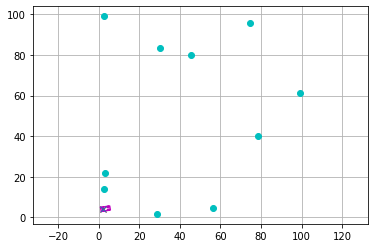

[0.4, 0.6632251157578462]
[2.27439198 4.11193651 0.49741884 0.4        0.66322512]


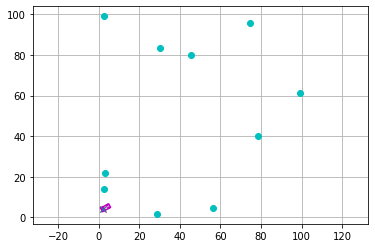

[0.5499999999999999, 0.4188790204786402]
[2.48350362 4.29053473 0.70685835 0.55       0.41887902]


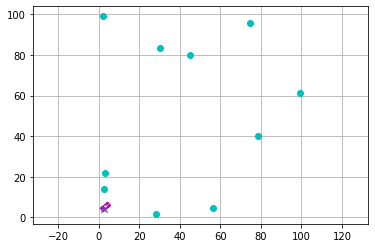

[0.6999999999999998, 0.2268928027592639]
[2.72220305 4.54650852 0.82030475 0.7        0.2268928 ]


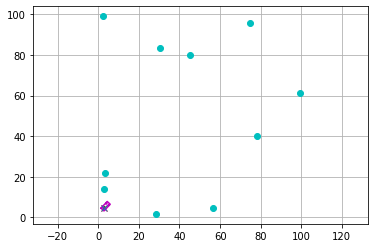

[0.8499999999999998, 0.13962634015954736]
[2.98966422 4.87679556 0.89011792 0.85       0.13962634]


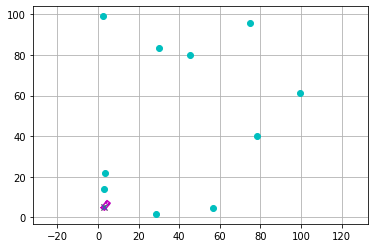

[0.9999999999999997, 0.06981317007977414]
[3.29057173 5.27611331 0.9250245  1.         0.06981317]


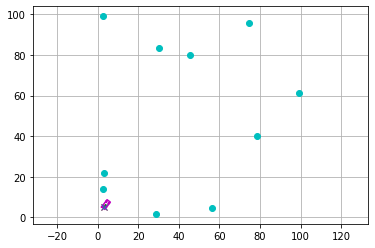

[1.1499999999999995, 0.05235987755983129]
[3.62447593 5.74422973 0.95120444 1.15       0.05235988]


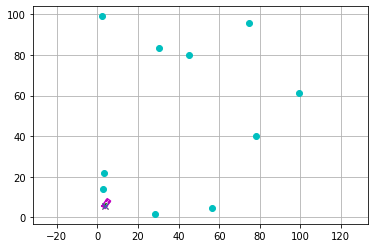

[1.2999999999999994, 0.01745329251994515]
[3.99730061 6.27667856 0.95993109 1.3        0.01745329]


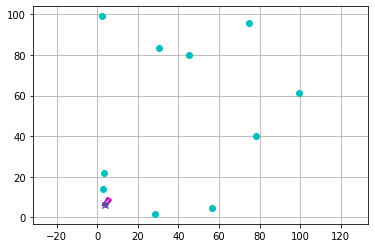

[1.4499999999999997, 0.01745329251994565]
[4.40794513 6.87417005 0.96865773 1.45       0.01745329]


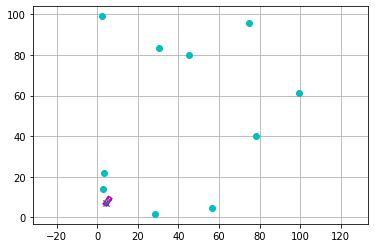

[1.6, 0.01745329251994615]
[4.85529945 7.53740011 0.97738438 1.6        0.01745329]


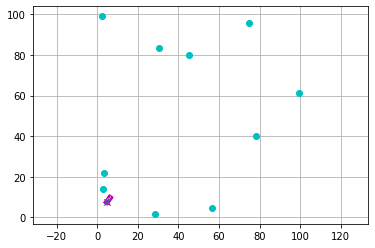

[1.7500000000000004, 3.3306690738754696e-15]
[5.34459325e+00 8.26280798e+00 9.77384381e-01 1.75000000e+00
 3.33066907e-15]


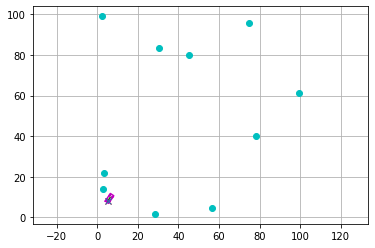

[1.9000000000000008, 3.83026943495679e-15]
[5.87582650e+00 9.05039368e+00 9.77384381e-01 1.90000000e+00
 3.83026943e-15]


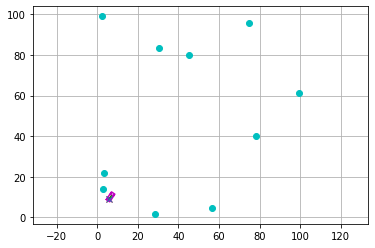

[2.050000000000001, 4.3298697960381105e-15]
[6.44899923e+00 9.90015719e+00 9.77384381e-01 2.05000000e+00
 4.32986980e-15]


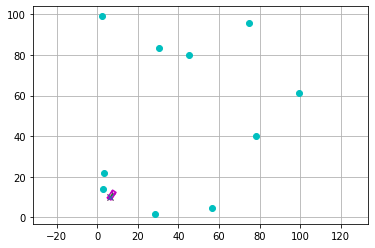

[2.2000000000000015, 4.829470157119431e-15]
[7.06411142e+00 1.08120985e+01 9.77384381e-01 2.20000000e+00
 4.82947016e-15]


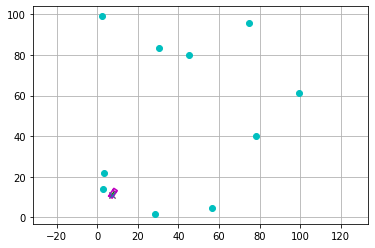

[2.350000000000002, 5.329070518200751e-15]
[7.72116309e+00 1.17862177e+01 9.77384381e-01 2.35000000e+00
 5.32907052e-15]


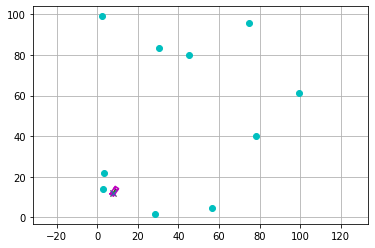

[2.500000000000002, 5.828670879282072e-15]
[8.42015421e+00 1.28225146e+01 9.77384381e-01 2.50000000e+00
 5.82867088e-15]


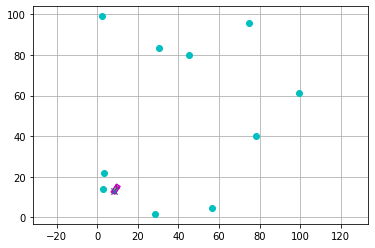

[2.6500000000000026, 6.328271240363392e-15]
[9.16108481e+00 1.39209894e+01 9.77384381e-01 2.65000000e+00
 6.32827124e-15]


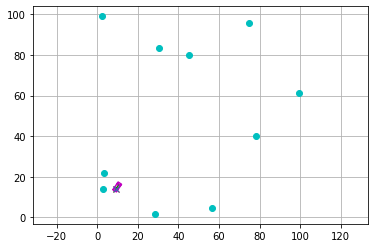

[2.800000000000003, 6.827871601444713e-15]
[9.94395488e+00 1.50816420e+01 9.77384381e-01 2.80000000e+00
 6.82787160e-15]


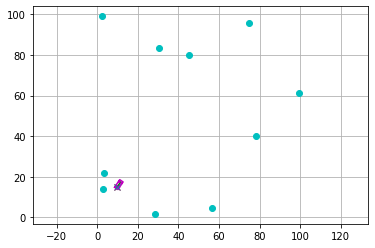

[2.9500000000000033, 7.327471962526033e-15]
[1.07687644e+01 1.63044724e+01 9.77384381e-01 2.95000000e+00
 7.32747196e-15]


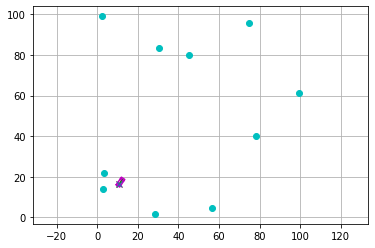

[3.1000000000000036, 7.827072323607354e-15]
[1.16355134e+01 1.75894807e+01 9.77384381e-01 3.10000000e+00
 7.82707232e-15]


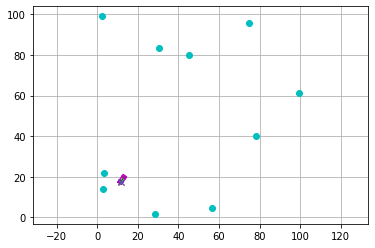

[3.250000000000004, 8.326672684688674e-15]
[1.25442019e+01 1.89366667e+01 9.77384381e-01 3.25000000e+00
 8.32667268e-15]


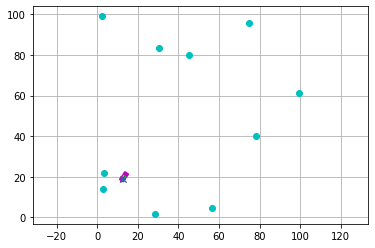

[3.4000000000000044, 8.826273045769994e-15]
[1.34948298e+01 2.03460306e+01 9.77384381e-01 3.40000000e+00
 8.82627305e-15]


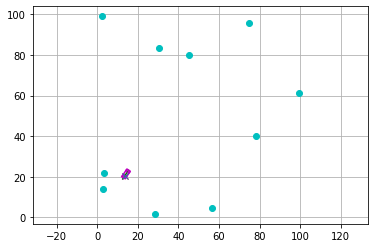

[3.5500000000000047, 9.325873406851315e-15]
[1.44873972e+01 2.18175723e+01 9.77384381e-01 3.55000000e+00
 9.32587341e-15]


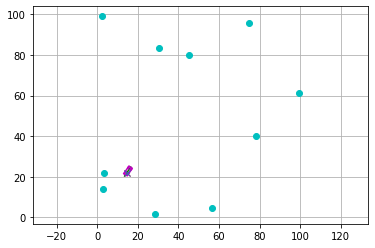

[3.700000000000005, 9.825473767932635e-15]
[1.55219041e+01 2.33512918e+01 9.77384381e-01 3.70000000e+00
 9.82547377e-15]


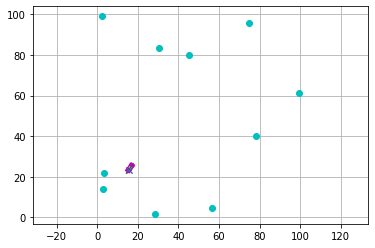

[3.8500000000000054, 1.0325074129013956e-14]
[1.65983504e+01 2.49471891e+01 9.77384381e-01 3.85000000e+00
 1.03250741e-14]


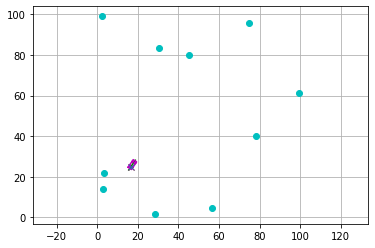

[4.000000000000005, 1.0824674490095276e-14]
[1.77167362e+01 2.66052643e+01 9.77384381e-01 4.00000000e+00
 1.08246745e-14]


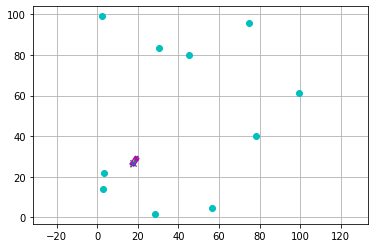

[4.150000000000006, 1.1324274851176597e-14]
[1.88770615e+01 2.83255172e+01 9.77384381e-01 4.15000000e+00
 1.13242749e-14]


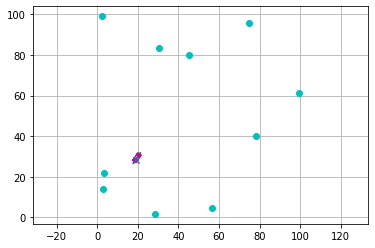

[4.300000000000004, 1.1823875212257917e-14]
[2.00793263e+01 3.01079480e+01 9.77384381e-01 4.30000000e+00
 1.18238752e-14]


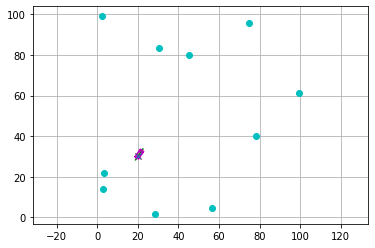

[4.450000000000003, 1.2323475573339238e-14]
[2.13235305e+01 3.19525566e+01 9.77384381e-01 4.45000000e+00
 1.23234756e-14]


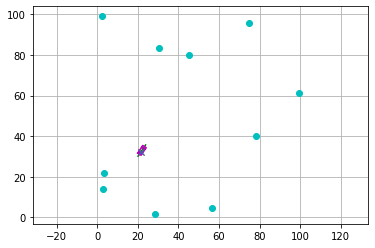

[4.600000000000001, 1.2823075934420558e-14]
[2.26096741e+01 3.38593430e+01 9.77384381e-01 4.60000000e+00
 1.28230759e-14]


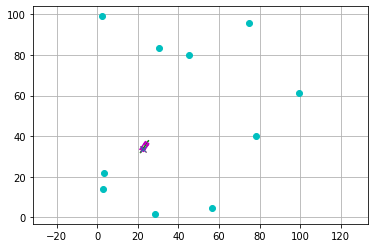

[4.75, 1.3322676295501878e-14]
[2.39377573e+01 3.58283073e+01 9.77384381e-01 4.75000000e+00
 1.33226763e-14]


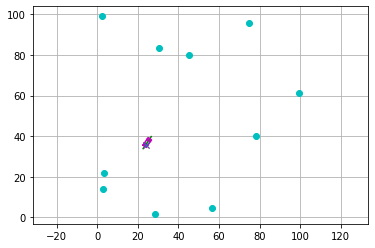

[4.899999999999999, 1.3822276656583199e-14]
[2.53077799e+01 3.78594493e+01 9.77384381e-01 4.90000000e+00
 1.38222767e-14]


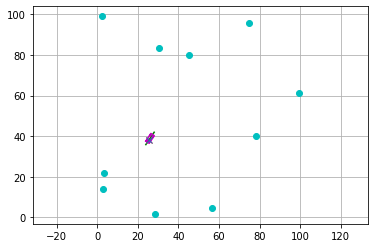

[4.9499999999999975, 1.432187701766452e-14]
[2.66917823e+01 3.99113173e+01 9.77384381e-01 4.95000000e+00
 1.43218770e-14]


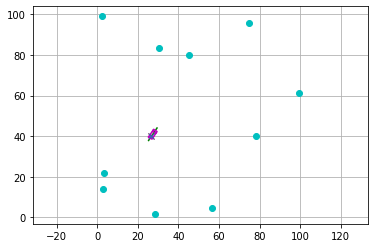

[4.9999999999999964, 1.482147737874584e-14]
[2.80897646e+01 4.19839112e+01 9.77384381e-01 5.00000000e+00
 1.48214774e-14]


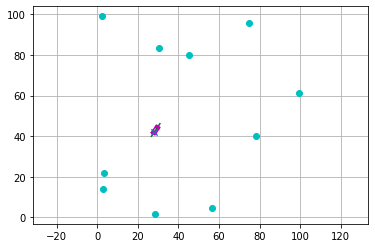

[4.949999999999996, 1.532107773982716e-14]
[2.94737670e+01 4.40357792e+01 9.77384381e-01 4.95000000e+00
 1.53210777e-14]


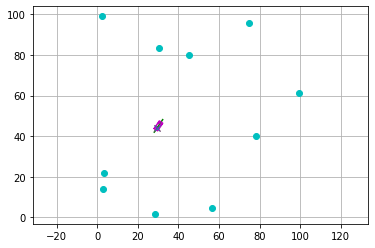

[4.999999999999995, 1.582067810090848e-14]
[3.08717493e+01 4.61083732e+01 9.77384381e-01 5.00000000e+00
 1.58206781e-14]


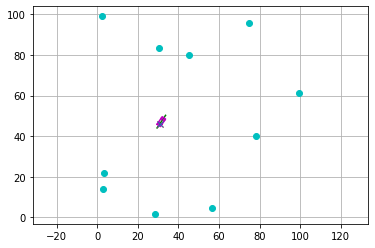

[4.949999999999994, 1.63202784619898e-14]
[3.22557517e+01 4.81602412e+01 9.77384381e-01 4.95000000e+00
 1.63202785e-14]


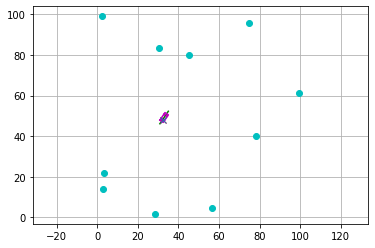

[4.999999999999993, 1.6819878823071122e-14]
[3.36537340e+01 5.02328351e+01 9.77384381e-01 5.00000000e+00
 1.68198788e-14]


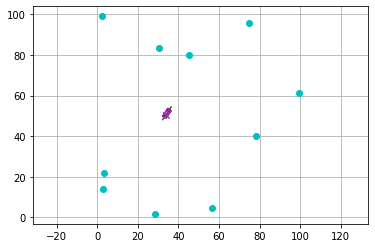

[4.949999999999992, 1.7319479184152442e-14]
[3.50377364e+01 5.22847031e+01 9.77384381e-01 4.95000000e+00
 1.73194792e-14]


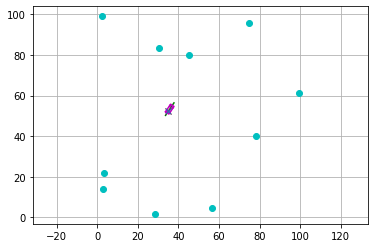

[4.999999999999991, 1.7819079545233762e-14]
[3.64357187e+01 5.43572970e+01 9.77384381e-01 5.00000000e+00
 1.78190795e-14]


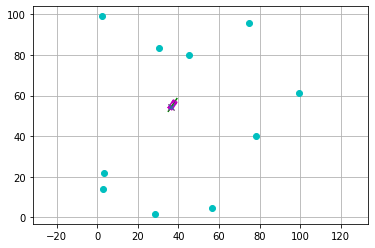

[4.94999999999999, 1.8318679906315083e-14]
[3.78197211e+01 5.64091650e+01 9.77384381e-01 4.95000000e+00
 1.83186799e-14]


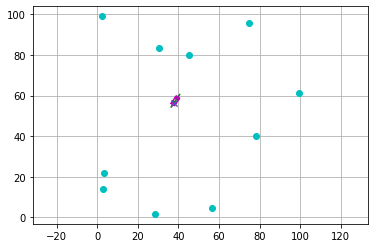

[4.999999999999989, 1.8818280267396403e-14]
[3.92177034e+01 5.84817589e+01 9.77384381e-01 5.00000000e+00
 1.88182803e-14]


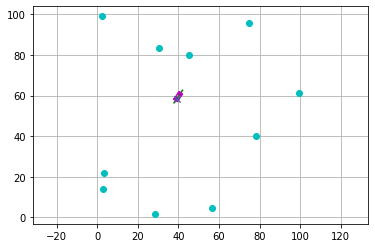

[4.949999999999989, 0.017453292519962638]
[4.05837474e+01 6.05456263e+01 9.86111027e-01 4.95000000e+00
 1.74532925e-02]


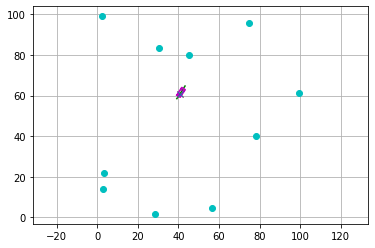

[4.999999999999988, 1.9817480989559044e-14]
[4.19635899e+01 6.26303409e+01 9.86111027e-01 5.00000000e+00
 1.98174810e-14]


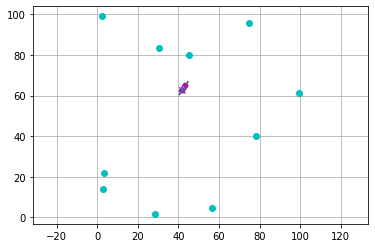

[4.949999999999987, 2.0317081350640365e-14]
[4.33296339e+01 6.46942083e+01 9.86111027e-01 4.95000000e+00
 2.03170814e-14]


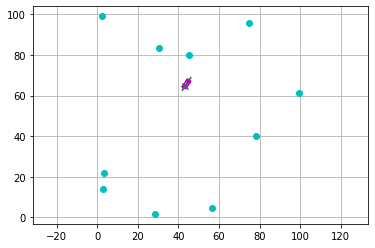

[4.999999999999986, 2.0816681711721685e-14]
[4.47094764e+01 6.67789229e+01 9.86111027e-01 5.00000000e+00
 2.08166817e-14]


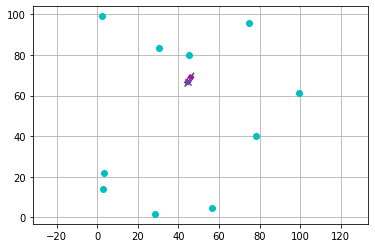

[4.949999999999985, 2.1316282072803006e-14]
[4.60755204e+01 6.88427903e+01 9.86111027e-01 4.95000000e+00
 2.13162821e-14]


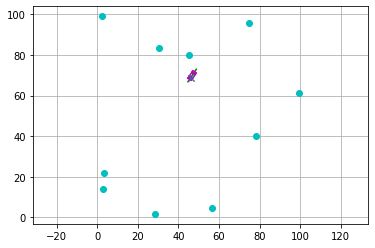

[4.999999999999984, 2.1815882433884326e-14]
[4.74553629e+01 7.09275048e+01 9.86111027e-01 5.00000000e+00
 2.18158824e-14]


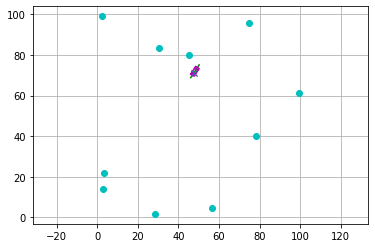

[4.949999999999983, 2.2315482794965646e-14]
[4.88214069e+01 7.29913722e+01 9.86111027e-01 4.95000000e+00
 2.23154828e-14]


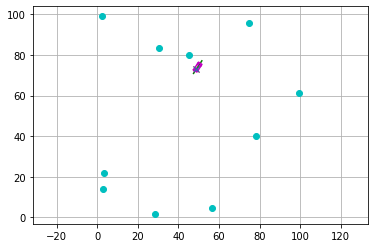

[4.999999999999982, 2.2815083156046967e-14]
[5.02012494e+01 7.50760868e+01 9.86111027e-01 5.00000000e+00
 2.28150832e-14]


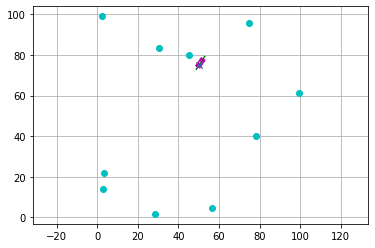

[4.9499999999999815, 2.3314683517128287e-14]
[5.15672934e+01 7.71399542e+01 9.86111027e-01 4.95000000e+00
 2.33146835e-14]


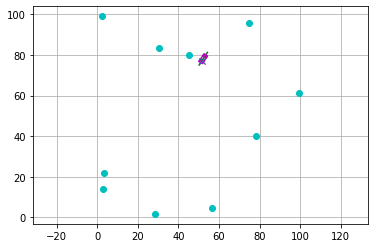

[4.9999999999999805, 2.3814283878209608e-14]
[5.29471359e+01 7.92246688e+01 9.86111027e-01 5.00000000e+00
 2.38142839e-14]


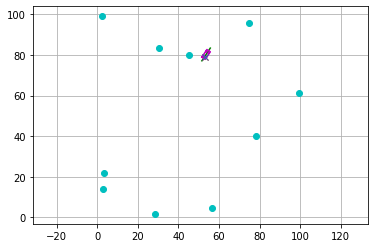

[4.94999999999998, 2.4313884239290928e-14]
[5.43131799e+01 8.12885362e+01 9.86111027e-01 4.95000000e+00
 2.43138842e-14]


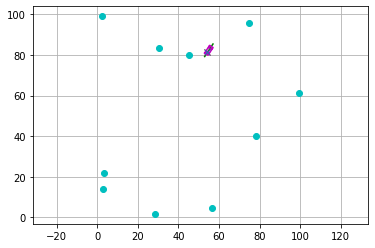

[4.999999999999979, 2.481348460037225e-14]
[5.56930224e+01 8.33732507e+01 9.86111027e-01 5.00000000e+00
 2.48134846e-14]


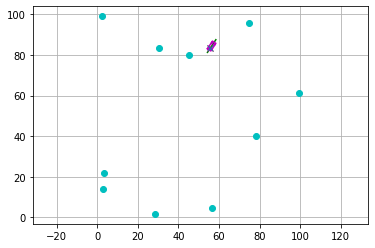

[4.949999999999978, 2.531308496145357e-14]
[5.70590664e+01 8.54371181e+01 9.86111027e-01 4.95000000e+00
 2.53130850e-14]


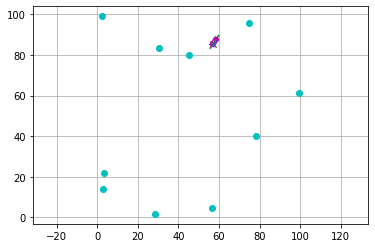

[4.699999999999978, 0.017453292519969132]
[5.83389682e+01 8.74079940e+01 9.94837674e-01 4.70000000e+00
 1.74532925e-02]


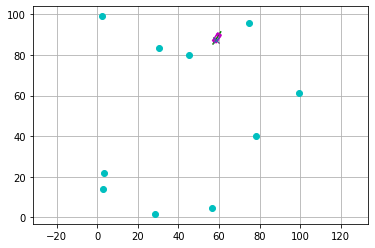

[4.449999999999978, 2.631228568361621e-14]
[5.95507900e+01 8.92740360e+01 9.94837674e-01 4.45000000e+00
 2.63122857e-14]


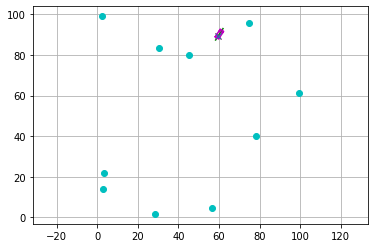

Goal!!
1
[4.199999999999978, -0.3490658503988396]
[60.98298656 90.80987876  0.82030475  4.2        -0.34906585]


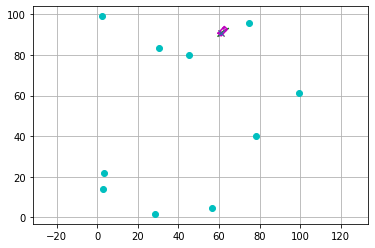

[4.3499999999999766, -0.6981317007977055]
[62.92092575 91.7973081   0.4712389   4.35       -0.6981317 ]


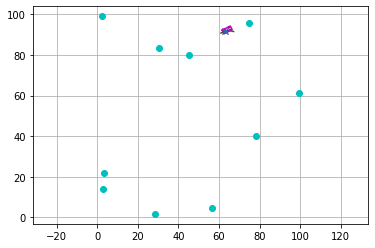

[4.499999999999975, -0.6981317007977318]
[65.1541546  92.07151412  0.12217305  4.5        -0.6981317 ]


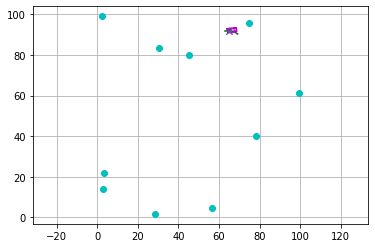

[4.649999999999974, -0.6981317007977318]
[67.419565   91.54850292 -0.2268928   4.65       -0.6981317 ]


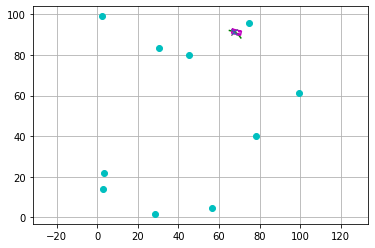

[4.799999999999972, -0.6981317007977318]
[69.43237436 90.24136923 -0.57595865  4.8        -0.6981317 ]


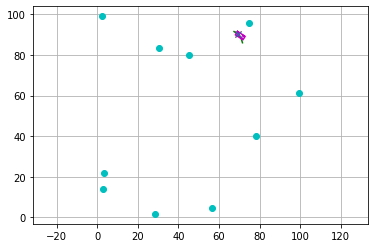

[4.949999999999971, -0.6981317007977318]
[70.92186654 88.26474635 -0.9250245   4.95       -0.6981317 ]


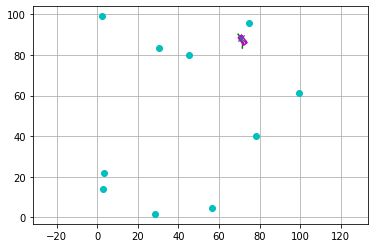

[4.99999999999997, -0.6981317007977318]
[71.6527958  85.87398446 -1.27409035  5.         -0.6981317 ]


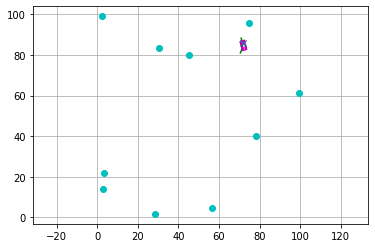

[4.949999999999969, -0.6457718232379018]
[71.58800786 83.39983258 -1.59697627  4.95       -0.64577182]


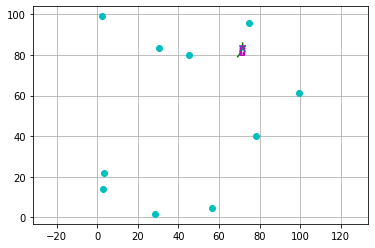

[4.999999999999968, -0.38397243543875204]
[71.04690882 80.95909256 -1.78896248  5.         -0.38397244]


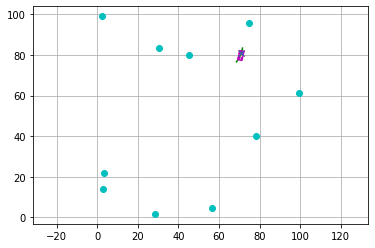

[4.949999999999967, -0.24434609527920548]
[70.22073685 78.62605487 -1.91113553  4.95       -0.2443461 ]


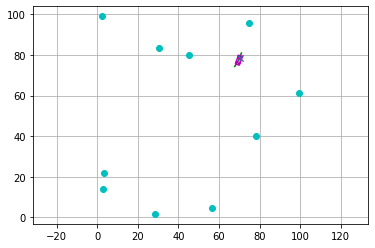

[4.999999999999966, -0.139626340159545]
[69.22386417 76.33340468 -1.9809487   5.         -0.13962634]


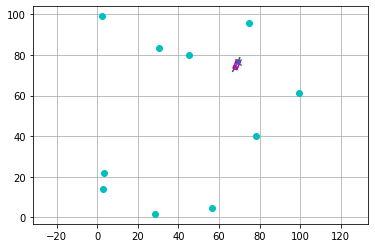

[4.9499999999999655, -0.08726646259971454]
[68.13889558 74.10888942 -2.02458193  4.95       -0.08726646]


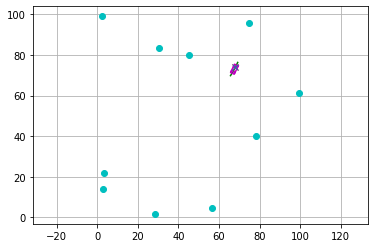

[4.9999999999999645, -0.06981317007977073]
[ 6.69652167e+01  7.19015204e+01 -2.05948852e+00  5.00000000e+00
 -6.98131701e-02]


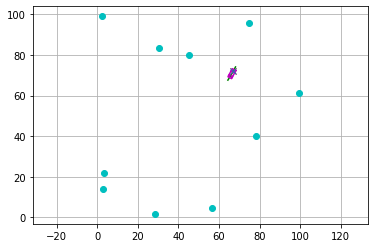

[4.949999999999964, -0.034906585039883586]
[ 6.57653129e+01  6.97368367e+01 -2.07694181e+00  4.95000000e+00
 -3.49065850e-02]


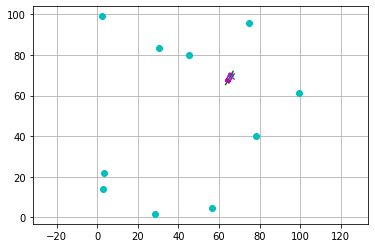

[4.999999999999963, -0.03490658503988309]
[ 6.45153129e+01  6.75717732e+01 -2.09439510e+00  5.00000000e+00
 -3.49065850e-02]


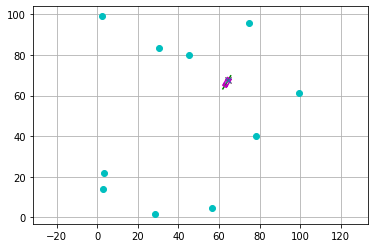

[4.949999999999962, -0.017453292519939267]
[ 6.32591554e+01  6.54392410e+01 -2.10312175e+00  4.95000000e+00
 -1.74532925e-02]


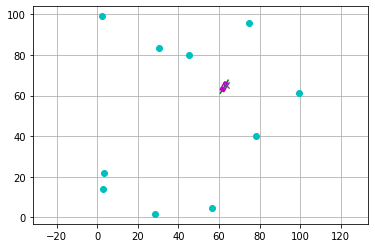

[4.699999999999962, 4.551914400963142e-15]
[ 6.20664403e+01  6.34144125e+01 -2.10312175e+00  4.70000000e+00
  4.55191440e-15]


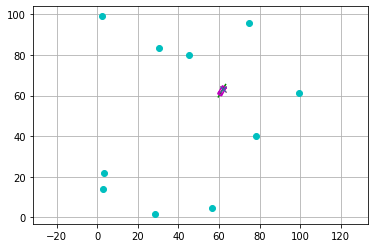

[4.449999999999962, -0.017453292519938268]
[ 6.09204805e+01  6.15072152e+01 -2.11184839e+00  4.45000000e+00
 -1.74532925e-02]


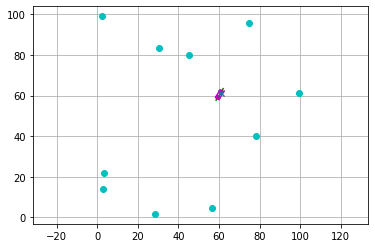

[4.199999999999962, -0.01745329251993777]
[ 5.98232336e+01  5.97166709e+01 -2.12057504e+00  4.20000000e+00
 -1.74532925e-02]


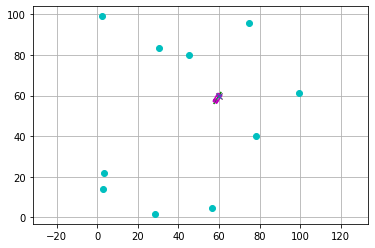

Goal!!
2
[3.949999999999962, 0.3141592653589858]
[59.06743378 57.89200879 -1.96349541  3.95        0.31415927]


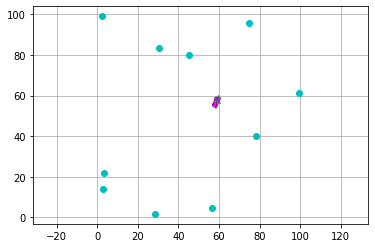

[4.099999999999962, 0.6457718232379084]
[58.92443301 55.84700248 -1.6406095   4.1         0.64577182]


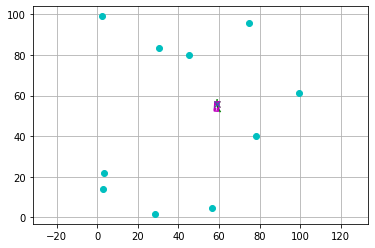

[4.249999999999963, 0.6806784082777955]
[59.49231456 53.79928777 -1.30027029  4.25        0.68067841]


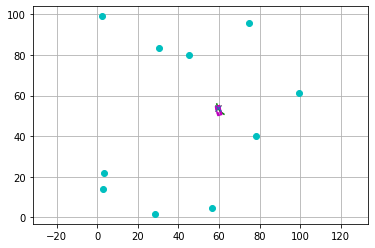

[4.399999999999961, 0.6806784082777959]
[60.75418272 51.99715327 -0.95993109  4.4         0.68067841]


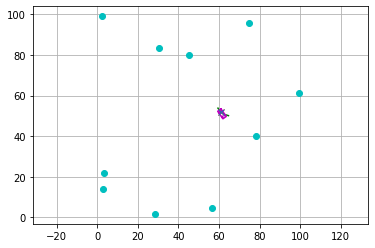

[4.54999999999996, 0.6806784082777964]
[62.60629553 50.67605405 -0.61959188  4.55        0.68067841]


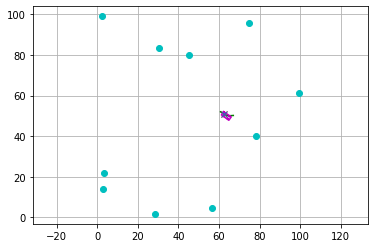

[4.699999999999958, 0.6806784082777968]
[64.86526051 50.02830626 -0.27925268  4.7         0.68067841]


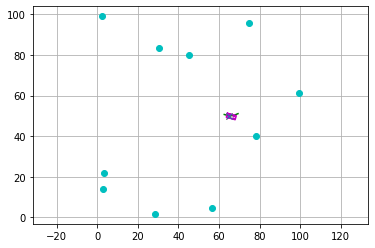

[4.849999999999957, 0.6806784082777972]
[6.72857374e+01 5.01763490e+01 6.10865238e-02 4.85000000e+00
 6.80678408e-01]


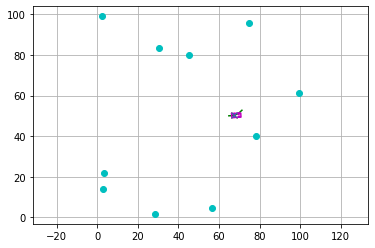

[4.999999999999956, 0.6806784082777977]
[69.58699953 51.15317679  0.40142573  5.          0.68067841]


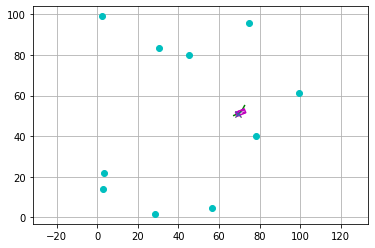

[4.949999999999955, 0.5410520681182516]
[71.52395472 52.69390052  0.67195176  4.95        0.54105207]


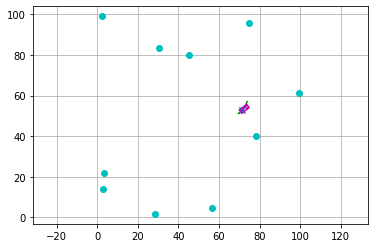

[4.999999999999954, 0.31415926535898875]
[73.21293024 54.53709386  0.82903139  5.          0.31415927]


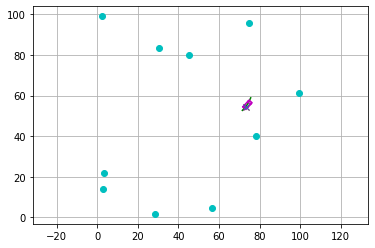

[4.949999999999953, 0.1745329251994424]
[74.71961478 56.50064338  0.91629786  4.95        0.17453293]


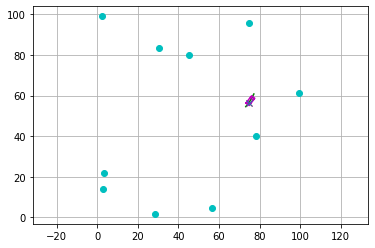

[4.999999999999952, 0.10471975511966919]
[76.13563037 58.56095885  0.96865773  5.          0.10471976]


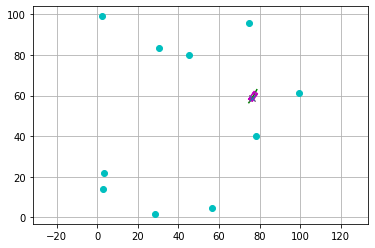

[4.949999999999951, 0.06981317007978255]
[7.74654469e+01 6.06483527e+01 1.00356432e+00 4.95000000e+00
 6.98131701e-02]


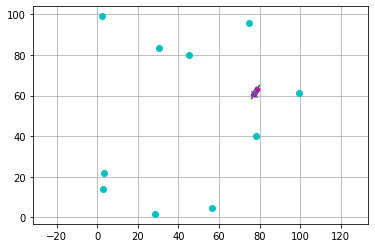

[4.99999999999995, 0.03490658503989641]
[7.87716933e+01 6.27799531e+01 1.02101761e+00 5.00000000e+00
 3.49065850e-02]


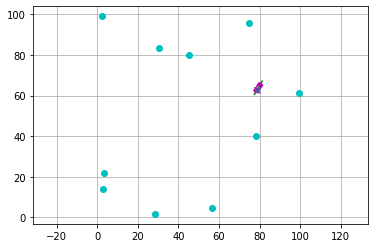

[4.9499999999999496, 0.03490658503989691]
[8.00278508e+01 6.49124853e+01 1.03847090e+00 4.95000000e+00
 3.49065850e-02]


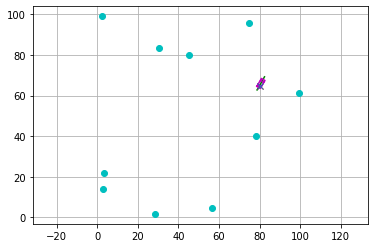

[4.9999999999999485, 0.01745329251995409]
[8.12778508e+01 6.70775488e+01 1.04719755e+00 5.00000000e+00
 1.74532925e-02]


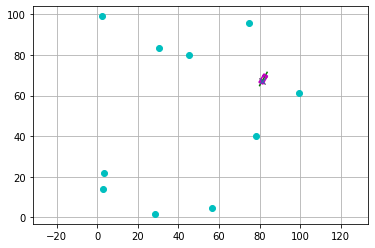

[4.949999999999948, 1.1268763699945339e-14]
[8.25153508e+01 6.92209616e+01 1.04719755e+00 4.95000000e+00
 1.12687637e-14]


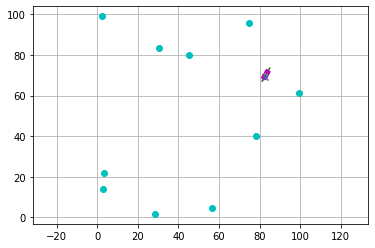

[4.999999999999947, 1.176836406102666e-14]
[8.37653508e+01 7.13860252e+01 1.04719755e+00 5.00000000e+00
 1.17683641e-14]


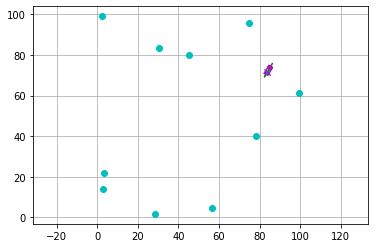

[4.949999999999946, 1.226796442210798e-14]
[8.50028508e+01 7.35294380e+01 1.04719755e+00 4.95000000e+00
 1.22679644e-14]


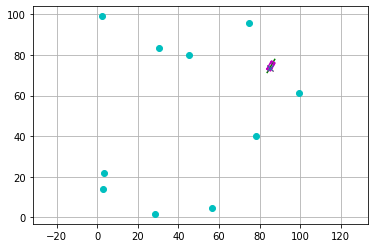

[4.999999999999945, 1.27675647831893e-14]
[8.62528508e+01 7.56945015e+01 1.04719755e+00 5.00000000e+00
 1.27675648e-14]


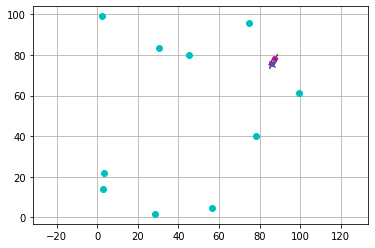

[4.949999999999944, 1.326716514427062e-14]
[8.74903508e+01 7.78379144e+01 1.04719755e+00 4.95000000e+00
 1.32671651e-14]


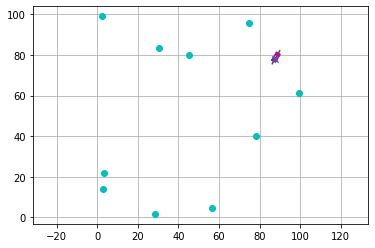

[4.999999999999943, 1.3766765505351941e-14]
[8.87403508e+01 8.00029779e+01 1.04719755e+00 5.00000000e+00
 1.37667655e-14]


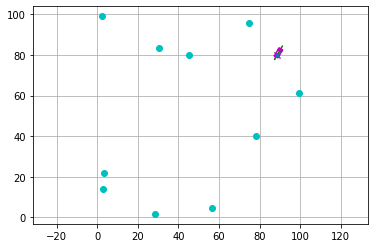

[4.9499999999999424, 0.017453292519957586]
[8.99590991e+01 8.21571083e+01 1.05592420e+00 4.95000000e+00
 1.74532925e-02]


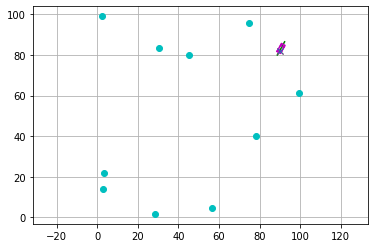

[4.999999999999941, 1.4765966227514582e-14]
[9.11901580e+01 8.43329975e+01 1.05592420e+00 5.00000000e+00
 1.47659662e-14]


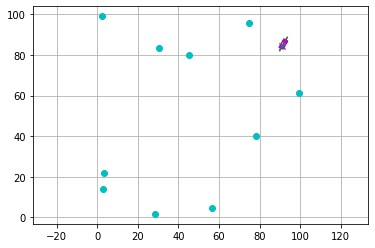

[4.949999999999941, 1.5265566588595902e-14]
[9.24089063e+01 8.64871279e+01 1.05592420e+00 4.95000000e+00
 1.52655666e-14]


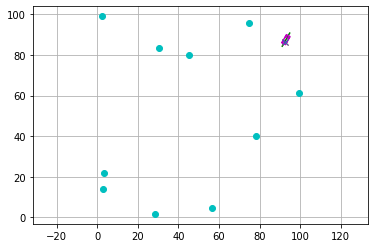

[4.99999999999994, 1.5765166949677223e-14]
[9.36399652e+01 8.86630171e+01 1.05592420e+00 5.00000000e+00
 1.57651669e-14]


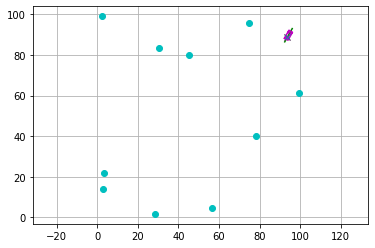

[4.949999999999939, 1.6264767310758543e-14]
[9.48587135e+01 9.08171474e+01 1.05592420e+00 4.95000000e+00
 1.62647673e-14]


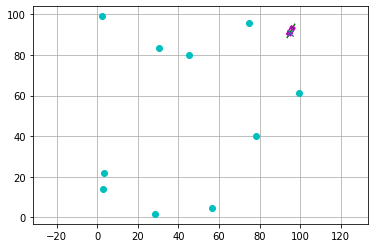

[4.999999999999938, 1.6764367671839864e-14]
[9.60897724e+01 9.29930367e+01 1.05592420e+00 5.00000000e+00
 1.67643677e-14]


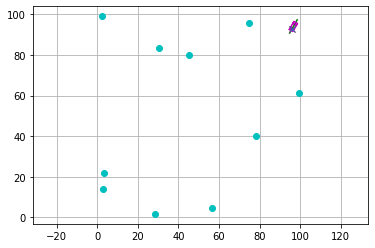

[4.949999999999937, 1.7263968032921184e-14]
[9.73085207e+01 9.51471670e+01 1.05592420e+00 4.95000000e+00
 1.72639680e-14]


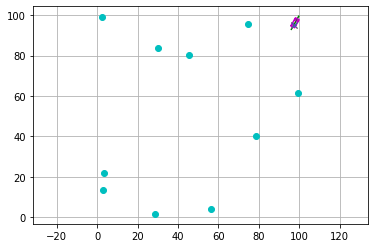

[4.699999999999937, 0.017453292519961083]
[9.84478233e+01 9.72025233e+01 1.06465084e+00 4.70000000e+00
 1.74532925e-02]


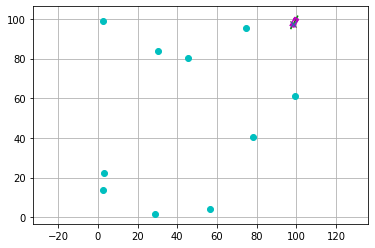

[4.449999999999937, 1.8263168755083825e-14]
[9.95265247e+01 9.91485522e+01 1.06465084e+00 4.45000000e+00
 1.82631688e-14]


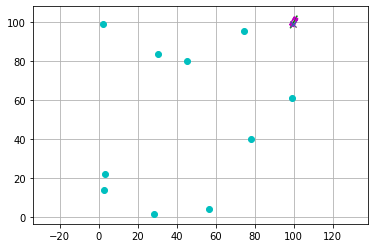

Goal!!
3
[4.199999999999937, -0.34906585039884763]
[100.84809754 100.78055871   0.89011792   4.2         -0.34906585]


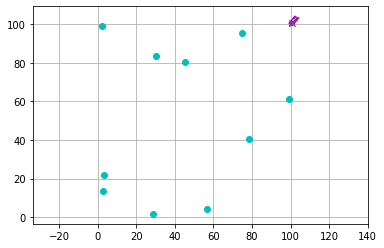

[4.349999999999936, -0.6981317007977135]
[102.71243642 101.90076652   0.54105207   4.35        -0.6981317 ]


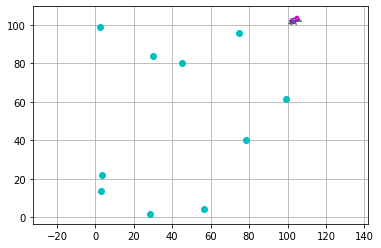

[4.499999999999934, -0.6981317007977318]
[104.92109758 102.33008676   0.19198622   4.5         -0.6981317 ]


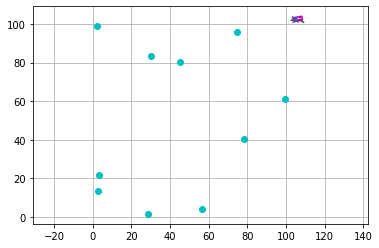

[4.649999999999933, -0.6981317007977318]
[107.21747297 101.96637663  -0.15707963   4.65        -0.6981317 ]


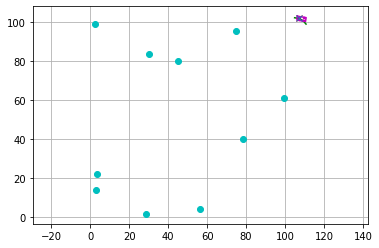

[4.799999999999931, -0.6981317007977318]
[109.31656027 100.80283354  -0.50614548   4.8         -0.6981317 ]


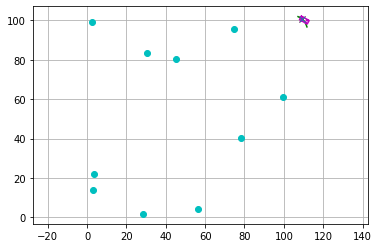

[4.94999999999993, -0.6981317007977318]
[110.94030637  98.93492733  -0.85521133   4.95        -0.6981317 ]


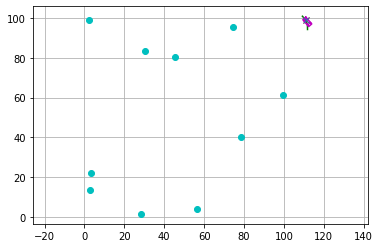

[4.999999999999929, -0.6981317007977318]
[111.83622624  96.60097627  -1.20427718   5.          -0.6981317 ]


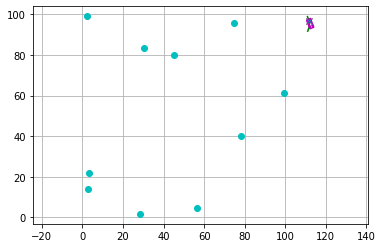

[4.949999999999928, -0.5061454830783553]
[112.11640419  94.14188592  -1.45734993   4.95        -0.50614548]


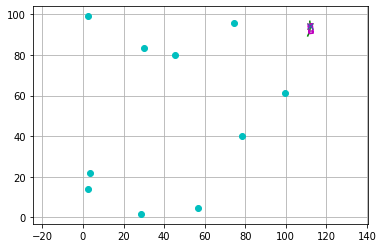

[4.999999999999927, -0.29670597283903544]
[112.02915545  91.64340886  -1.60570291   5.          -0.29670597]


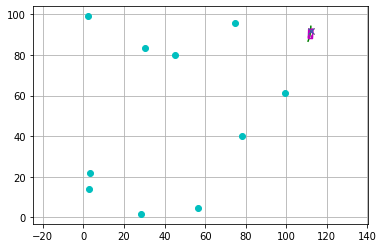

[4.9499999999999265, -0.17453292519943164]
[111.72752883  89.18685713  -1.69296937   4.95        -0.17453293]


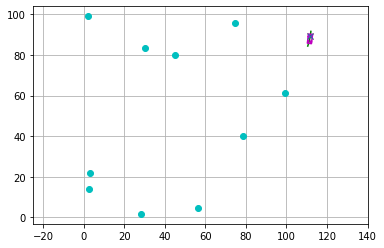

[4.999999999999925, -0.10471975511965792]
[ 1.11293408e+02  8.67248377e+01 -1.74532925e+00  5.00000000e+00
 -1.04719755e-01]


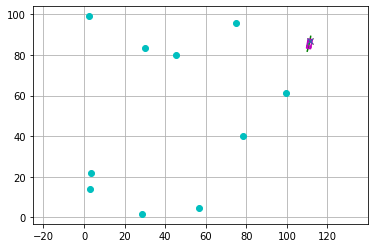

[4.949999999999925, -0.05235987755982746]
[ 1.10799973e+02  8.42995241e+01 -1.77150919e+00  4.95000000e+00
 -5.23598776e-02]


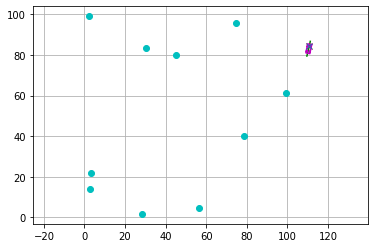

[4.999999999999924, -0.03490658503988364]
[ 1.10258874e+02  8.18587841e+01 -1.78896248e+00  5.00000000e+00
 -3.49065850e-02]


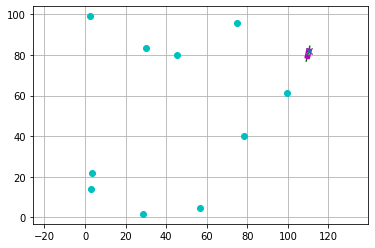

[4.949999999999923, -0.017453292519939823]
[ 1.09702120e+02  7.94472182e+01 -1.79768913e+00  4.95000000e+00
 -1.74532925e-02]


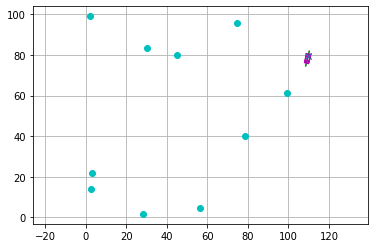

[4.999999999999922, -0.017453292519939323]
[ 1.09118506e+02  7.70162934e+01 -1.80641578e+00  5.00000000e+00
 -1.74532925e-02]


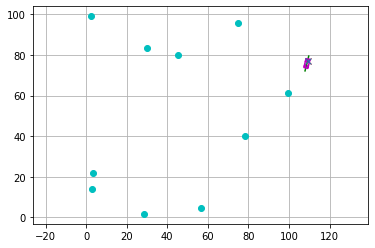

[4.949999999999921, 4.496403249731884e-15]
[ 1.08540729e+02  7.46096778e+01 -1.80641578e+00  4.95000000e+00
  4.49640325e-15]


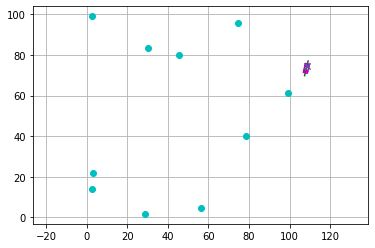

[4.99999999999992, 4.9960036108132044e-15]
[ 1.07957116e+02  7.21787530e+01 -1.80641578e+00  5.00000000e+00
  4.99600361e-15]


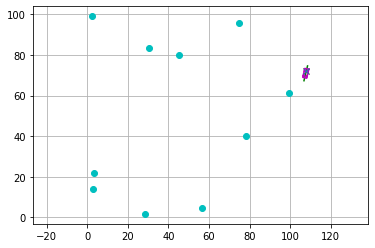

[4.949999999999919, 5.495603971894525e-15]
[ 1.07379338e+02  6.97721375e+01 -1.80641578e+00  4.95000000e+00
  5.49560397e-15]


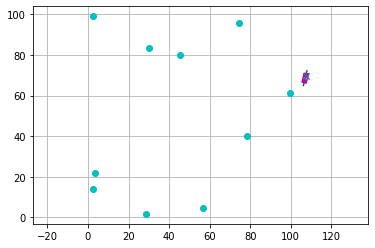

[4.999999999999918, 5.995204332975845e-15]
[ 1.06795725e+02  6.73412127e+01 -1.80641578e+00  5.00000000e+00
  5.99520433e-15]


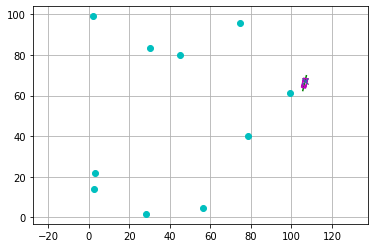

[4.949999999999918, 6.494804694057166e-15]
[ 1.06217948e+02  6.49345971e+01 -1.80641578e+00  4.95000000e+00
  6.49480469e-15]


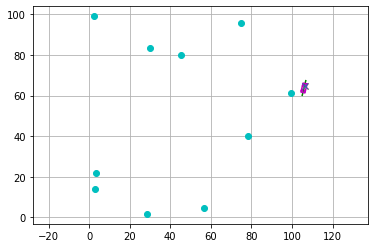

[4.9999999999999165, 6.994405055138486e-15]
[ 1.05634334e+02  6.25036723e+01 -1.80641578e+00  5.00000000e+00
  6.99440506e-15]


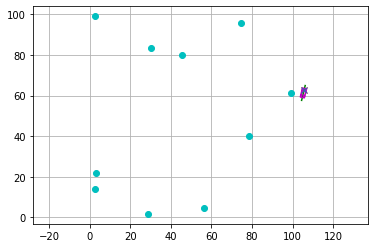

[4.949999999999916, 7.494005416219807e-15]
[ 1.05056557e+02  6.00970568e+01 -1.80641578e+00  4.95000000e+00
  7.49400542e-15]


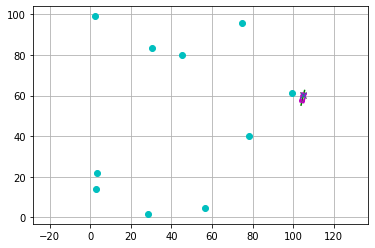

[4.999999999999915, -0.017453292519935326]
[ 1.04451752e+02  5.76713174e+01 -1.81514242e+00  5.00000000e+00
 -1.74532925e-02]


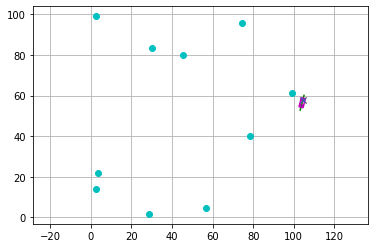

[4.949999999999914, 8.493206138382448e-15]
[ 1.03852996e+02  5.52698355e+01 -1.81514242e+00  4.95000000e+00
  8.49320614e-15]


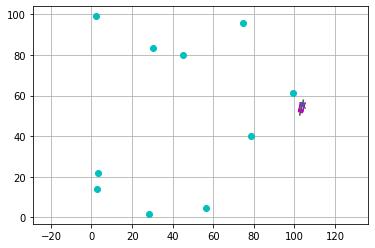

[4.999999999999913, 8.992806499463768e-15]
[ 1.03248191e+02  5.28440962e+01 -1.81514242e+00  5.00000000e+00
  8.99280650e-15]


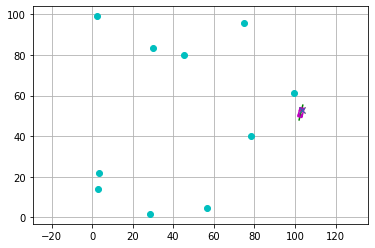

[4.949999999999912, 9.492406860545088e-15]
[ 1.02649434e+02  5.04426143e+01 -1.81514242e+00  4.95000000e+00
  9.49240686e-15]


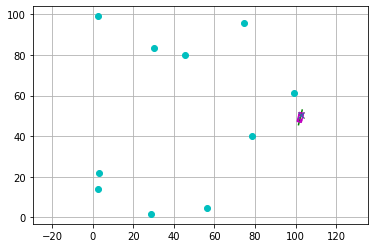

[4.999999999999911, 9.992007221626409e-15]
[ 1.02044630e+02  4.80168750e+01 -1.81514242e+00  5.00000000e+00
  9.99200722e-15]


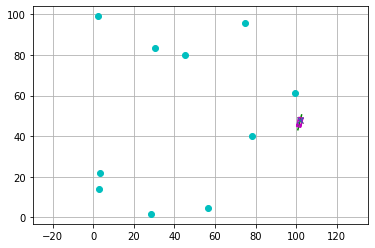

[4.9499999999999105, 1.049160758270773e-14]
[ 1.01445873e+02  4.56153930e+01 -1.81514242e+00  4.95000000e+00
  1.04916076e-14]


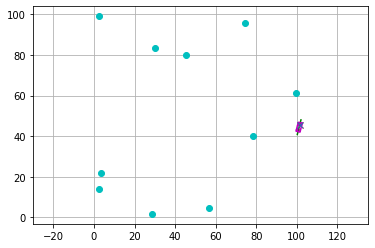

[4.6999999999999105, 1.099120794378905e-14]
[ 1.00877356e+02  4.33351981e+01 -1.81514242e+00  4.70000000e+00
  1.09912079e-14]


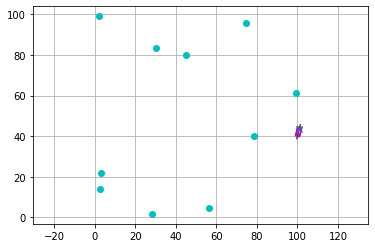

[4.4499999999999105, -0.01745329251993183]
[ 1.00320261e+02  4.11810696e+01 -1.82386907e+00  4.45000000e+00
 -1.74532925e-02]


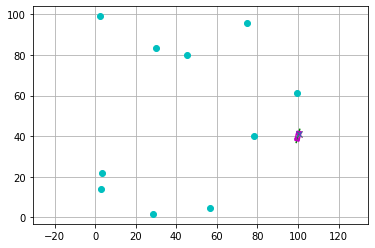

[4.1999999999999105, -0.03490658503987465]
[ 9.97590603e+01  3.91574456e+01 -1.84132236e+00  4.20000000e+00
 -3.49065850e-02]


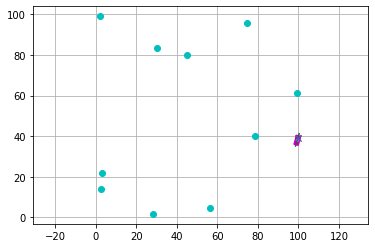

Goal!!
Done


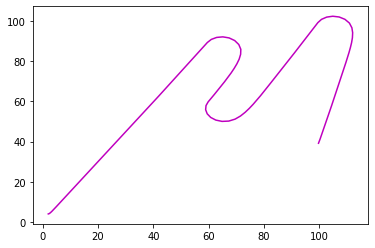

In [19]:

if __name__ == '__main__':
    main()
